# Chapter 15   
***  
## Processing Sequences Using RNNs and CNNs  
***

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [6]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [17]:
import tensorflow
import time
import tensorflow.keras
import tensorflow.keras.applications as kapp
from tensorflow.keras.datasets import cifar10

(x_train, y_train_cats), (x_test, y_test_cats) = cifar10.load_data()
batch_size = 8
x_train = x_train[:batch_size]
x_train = np.repeat(np.repeat(x_train, 7, axis=1), 7, axis=2)
model = kapp.VGG19()
model.compile(optimizer='sgd', loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Running initial batch (compiling tile program)")
y = model.predict(x=x_train, batch_size=batch_size)

# Now start the clock and run 10 batches
print("Timing inference...")
start = time.time()
for i in range(10):
    y = model.predict(x=x_train, batch_size=batch_size)
print("Ran in {} seconds".format(time.time() - start))

Running initial batch (compiling tile program)
Timing inference...
Ran in 33.5510892868042 seconds


# Basic RNNs  
***  
 - analyze `time series data` such as `stock prices`, and tell you when to buy or sell.  
 - In `autonomous driving systems`, they can anticipate car trajectories and help avoid accidents.  
 - making them extremely useful for `natural language processing applications` such as automatic translation or speech-to-text.  
  <font color=gray>주식 가격과 같은 시계열데이터 분석가능, 또한 NLP, 자율주행에서 사고방지를 위해 사용된다. </font>
 
 <br> 
 - how to train them using backpropagation through time,   
 - then we will use them to forecast a time series.   
 - After that we’ll explore the two main difficulties that RNNs face:  
  1. `Unstable gradients`  
  2. `(very) limited short-term memory`, which can be extended using LSTM and GRU cells  

<br>

RNNs are not the only types of neural networks capable of handling sequential data:   
 - for small sequences, a `regular dense network` can do the trick;  
 - and for very long sequences, such as audio samples or text, `convolutional neural networks` can   
 <font color=gray>RNN 외에도 작은 연속데이터에서는 regular dense network, 아주 긴 연속데이터에서는  convolutional neural networks를 쓸수 있다.  </font>

#### Output of a recurrent layer for a single instance  
$y_{(t)} =\phi(W_{x}^⊺x_{(t)} +W_{y}^⊺y_{(t−1)} +b)$   
  
Each recurrent neuron has two sets of weights:   
 - one for the inputs $x_{(t)}$   
 - and the other for the outputs of the previous time step, $y_{(t–1)}$  
 - weight vectors w$_x$ and $w_y$  
 - $b$ is the bias vector and $φ(·)$ is the activation function    


#### Outputs of a layer of recurrent neurons for all instances in a mini-batch 
$\qquad  = \phi( \left[\begin{matrix}X_{(t)} & Y_{(t−1)} \end{matrix}\right] W+b)\;with\;W =$ 
$\left[
\begin{matrix}
W_x \\
W_y
\end{matrix}[
\right]$
  
  - $Y_{(t)}$ is an $m × n_{neurons}$  
  $m$ is the number of instances in the mini-batch and nneurons is the number of neurons  
  - $X_{(t)}$ is an $m × n_{inputs}$ matrix containing the inputs for all instances  
  - $W_x$ is an $n_{inputs} × n_{neurons}$ matrix containing the connection weights for the `inputs` of the `current time step`.  
  - $W_y$ is an $n_{inputs} × n_{neurons}$  matrix containing the connection weights for the `outputs` of the `previous time step`.  
  - `b` is a vector of size $n_{neurons}$ containing each neuron’s bias term  
  - concatenated vertically into a single weight matrix W of shape $(n_{inputs} + n_{neurons}) × n_{neurons}$   
  - $\left[\begin{matrix}X_{(t)} & Y_{(t−1)} \end{matrix}\right]$ horizontal concatenation of the matrices $X_{(t)} and Y_{(t–1)}$.
 
#### t = 0, there are no previous outputs, so they are typically assumed to be all zeros.    
<font color=gray> t=0일때 시작점이라 이전 아웃풋이 없다 그래서 0으로 가정 </font>
 
<br>  
##### many researchers prefer to use the hyperbolic `tangent (tanh)` activation function in RNNs rather than the `ReLU` activation function  
<font color=gray>많은 리서처들이 RNN에서 ReLu 보다 tanh 활성함수를 선호한다 </font>

# Memory Cells  
***  
1. output of a recurrent neuron at time step t  
 -  function of all the inputs from previous time steps  

 <font color=gray>t 일때 리커런트 뉴런(recurrent neuron)의 아웃풋은 그전 단계의 인풋들의 함수다.</font>
2. part of a neural network that preserves some state across time steps is called a `memory cell`  
<font color=gray></font>
3. Single recurrent neuron, or a layer of recurrent neurons, is a very basic cell,   
`capable of learning only short patterns` (typically about 10 steps long, but this varies depending on the task)  
<font color=gray>recurrent neuron은 10 스텝 정도의 짧은 패턴을 학습 할 수있다</font>
4. `At time step t`, denoted $h_{(t)}$ (the “h” stands for “hidden”), is a function of some inputs at that time step  
and its state at the `previous time step`: $h_{(t)} = f(h_{(t–1)}, x_{(t)})$   
<font color=gray> x=0 일때  $h_{(0)} = f(h_{(0-1)}, x_{(0)})$  
    x=1 일때  $h_{(1)} = f(h_{(0)}, x_{(1)})$ </font>
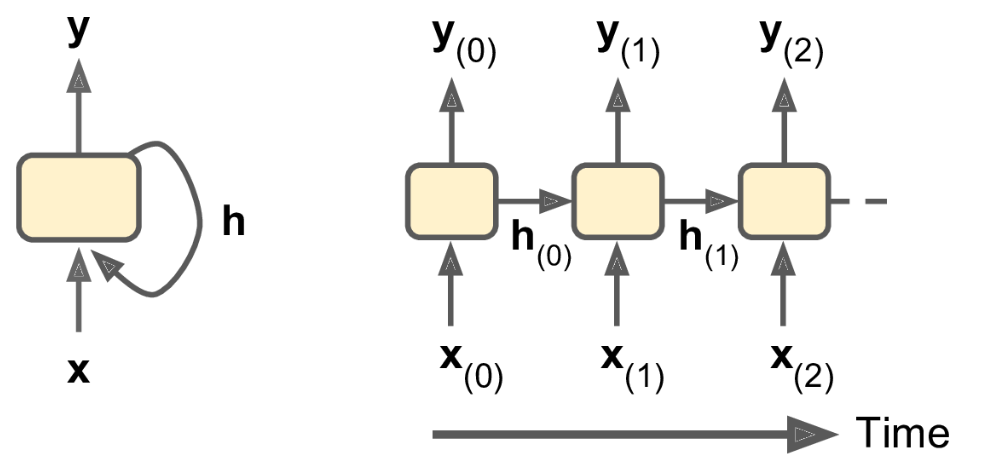

# Input and Output Sequences  
***  
1. RNN can simultaneously take a sequence of inputs and produce a sequence of outputs  
`sequence-to-sequence network`  
 - useful for predicting time series such as stock prices  
 <font color=gray>시퀀스-투-시퀀스: 주가와 같은 타임시리즈 예측에 좋다  </font>
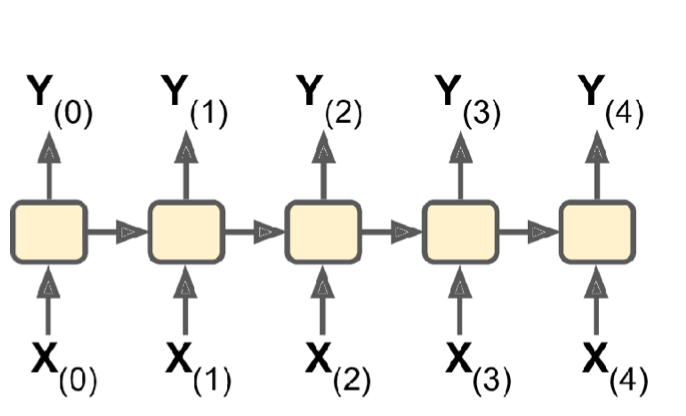

2. feed the network a sequence of inputs and `ignore all outputs except for the last one`  
 `sequence-to-vector network`.  
  -  feed the network a sequence of words corresponding to a movie review, and the network would output a sentiment score (e.g., from –1 [hate] to +1 [love]).  
  <font color=gray>시퀀스-투-벡터: 마지막 아웃풋 뺴고 다 무시</font>
 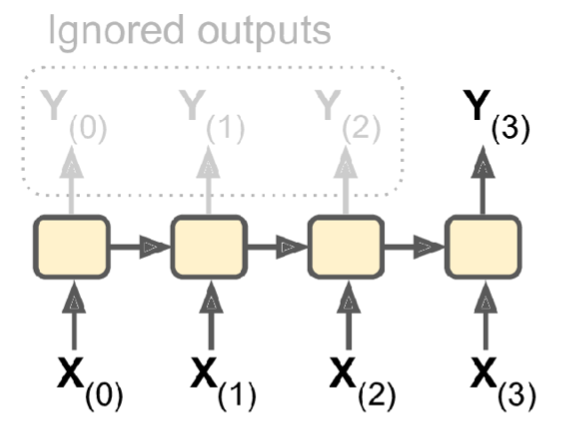

3. could feed the network the same input vector over and over again at each time step and let it output a sequence.  
`Vector-to-sequence network`  
 -  input could be an image (or the output of a CNN), and the output could be a caption for that image.   
 <font color=gray>벡터-투-시퀀스: 같은 인풋 벡터가 계속 쓰인다 </font>
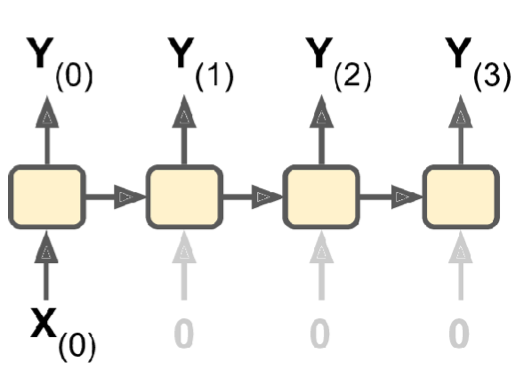

4. could have a sequence-to-vector network, called an encoder, followed by a vector-to-sequence network, called a decoder    
`Encoder–Decoder`  
 -  translating a sentence from one language to another. You would feed the network a sentence in one language, the `encoder` would convert this sentence into a single vector representation, and then the `decoder` would decode this vector into a sentence in another language  
 <font color=gray>시퀀스-투-벡터(인코더)-> 벡터-투-시퀀스(디코더): 문장 번역, 인코더에서 문장을 싱글 벡터로, 디코더에서 다른언어의 문장으로 </font>
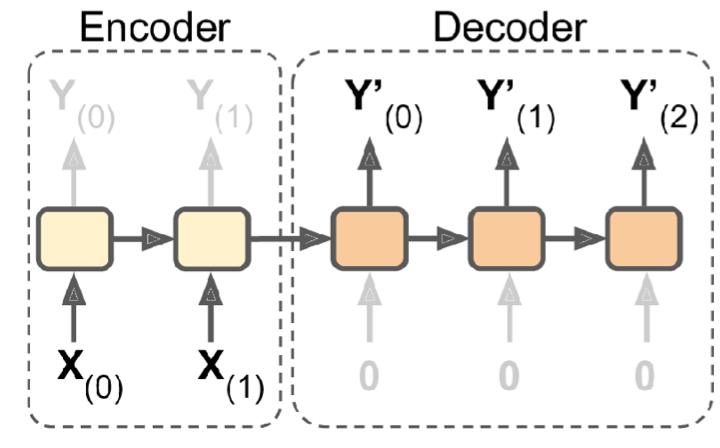

# Training RNNs
***  
`backpropagation through time (BPTT)`  
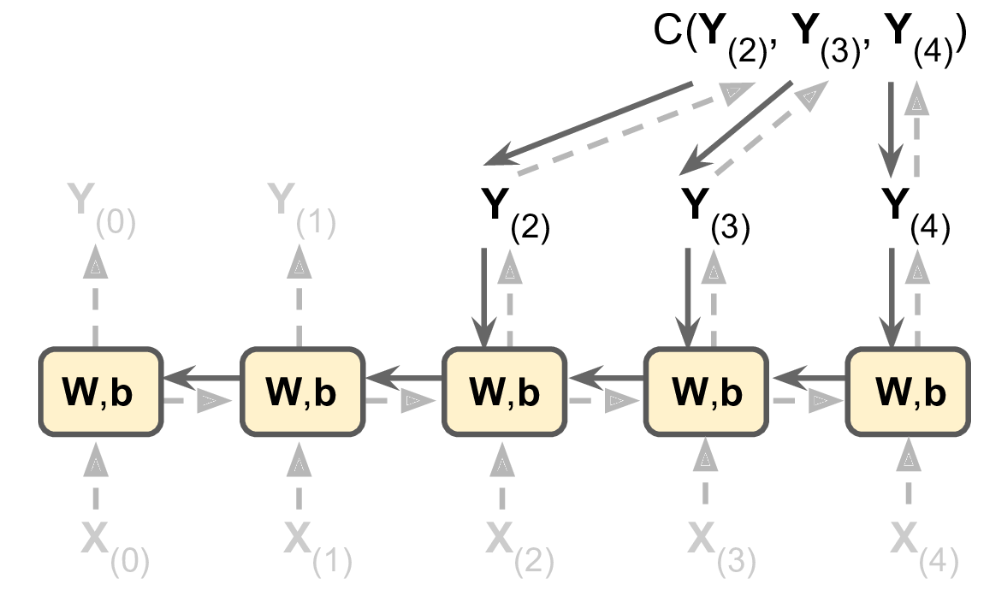  
 - first forward pass through the unrolled network (represented by the dashed arrows)  
 - output sequence is evaluated using a cost function $C(Y_{(0)}, Y_{(1)}, ...Y_{(T)}$)  
 - gradients of that cost function are then propagated backward through the unrolled network (represented by the solid arrows)  
 - Finally the model parameters are updated using the gradients computed during BPTT.  
  cost function is computed using the last three out‐ puts of the network, $Y_{(2)}, Y_{(3)}$, and $Y_{(4)}$, so gradients flow through these three outputs, but not through $Y_{(0)}$ and $ Y_{(1)}$)

# Forecasting a Time Series   
***   
`univariate time series`
 - is a single value per time step  
 - active users per hour on your website. 
 - the daily temperature in your city  

`company’s financial health`  
 - multiple values per time step  
 - the company’s revenue, debt  

  
 - typical task is to predict future values, which is called `forecasting`   
 - common task is to fill in the blanks: to predict (or rather “postdict”) missing values from the past. This is called `imputation`  
 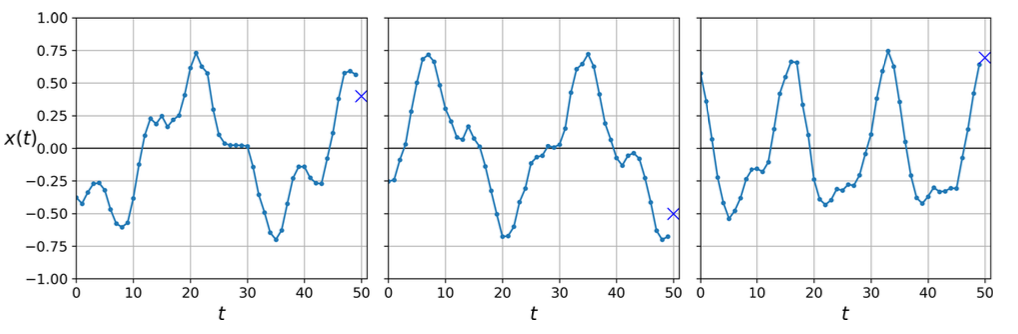
### Generate the Dataset  
 -  <font color=pink>generate_time_series()</font>  
 - input features are generally represented as `3D arrays` of shape `[batch size, time steps, dimensionality]`,  
  - where dimensionality is 1 for `univariate` time series   
  - and more for `multivariate` time series.  
  <font color=gray>3D array [배치크기, 시간단계, 차원]  
1: 단변량(분포가 변량이 하나인), 2이상: 다변량</font>


In [2]:
# one value per time step in each series
# returns a NumPy array of shape [batch size, time steps, 1]
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
# X_train contains 7,000 time series (i.e., its shape is [7000, 50, 1])
# X_valid contains 2,000 (from the 7,000th time series to the 8,999th)  
# X_test contains 1,000 (from the 9,000th to the 9,999th)  

# want to forecast a single value for each series, 
# the targets are column vectors (e.g., y_train has a shape of [7000, 1]).
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
series.shape

(10000, 51, 1)

In [5]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [6]:
X_valid.shape, y_valid.shape

((2000, 50, 1), (2000, 1))

In [7]:
X_valid[:,-1].shape

(2000, 1)

In [8]:
X_valid[:,-1,-1].shape

(2000,)

Saving figure time_series_plot


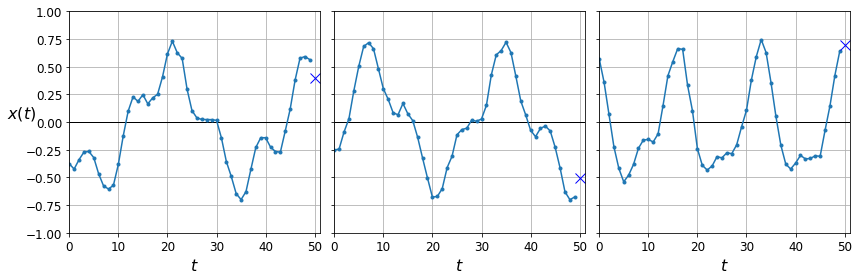

In [9]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

### Computing Some Baselines  
 -  good idea to have a few baseline metrics.  
  - simplest approach is to predict the last value in each series. This is called `naive forecasting`  
 - Another simple approach is to use a fully connected network.  


Naive predictions (just predict the last observed value):

In [10]:
# Naive predictions 평균 MSE  y_valid, y_pred = (2000, 1)
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

In [11]:
y_pred

array([[ 0.5643068 ],
       [-0.6759614 ],
       [ 0.64214784],
       ...,
       [-0.19055651],
       [-0.1811238 ],
       [ 0.42333305]], dtype=float32)

In [12]:
y_valid

array([[ 0.4000832 ],
       [-0.50259125],
       [ 0.69304645],
       ...,
       [-0.25712416],
       [-0.2791788 ],
       [ 0.6290542 ]], dtype=float32)

In [13]:
X_valid[0, :, 0]

array([-0.3761855 , -0.42404684, -0.3390344 , -0.271153  , -0.26532513,
       -0.32099137, -0.46815926, -0.5769794 , -0.6041072 , -0.5708584 ,
       -0.38275763, -0.12439152,  0.09827511,  0.22865155,  0.18679029,
        0.24767214,  0.16514015,  0.21874566,  0.25152925,  0.40883926,
        0.615185  ,  0.73059636,  0.6266374 ,  0.5755195 ,  0.29736876,
        0.10385749,  0.03801422,  0.02386243,  0.02322038,  0.02215886,
        0.01596526, -0.14356734, -0.35600615, -0.49090433, -0.64607924,
       -0.70009744, -0.62788457, -0.4255847 , -0.22938487, -0.14113732,
       -0.14108056, -0.22598805, -0.26593843, -0.271487  , -0.07883997,
        0.1177286 ,  0.3792994 ,  0.5767727 ,  0.59239095,  0.5643068 ],
      dtype=float32)

In [14]:
y_valid[0, 0]

0.4000832

In [15]:
y_pred[0, 0]

0.5643068

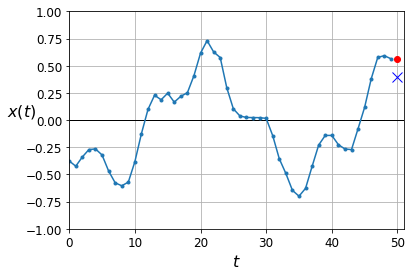

In [16]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Linear predictions:  
 - Linear Regression model so that each prediction will be a linear combination of the values in the time series:  
 <font color=gray>선형 회귀, input_shape=[50, 1]</font>

In [17]:
# Linear Regression 
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

# compile this model using the MSE loss and the default Adam optimizer,
# then fit it on the training set for 20 epochs and evaluate it on the validation set
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0062

In [18]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0042


0.004168087150901556

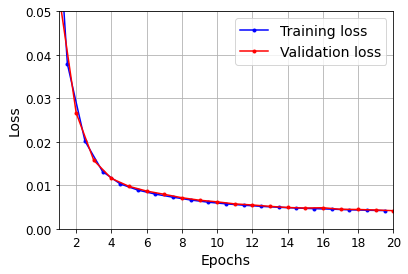

In [19]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))    #?
    plt.axis([1, 20, 0, 0.05])    # x축: 1~20, y축: 0~0.05
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

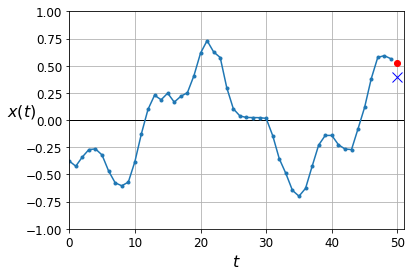

In [20]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Simple RNN  
***  
 - just contains a single layer, with a single neuron  
 - do not need to specify the length of the input sequences  
 - recurrent neural network can process any number of time steps   
 (this is why we set the `first input dimension` to `None`)  
 - `default`, the SimpleRNN layer uses the `hyperbolic tangent` activation function.  
 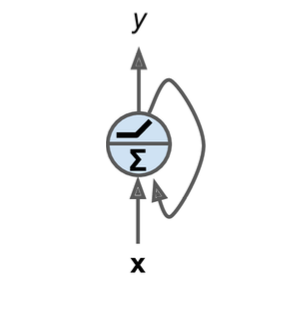  
 - initial state $h_{(init)}$ is set to 0  
 - along with the value of the first time step, $x_{(0)}$  
 - The neuron computes a weighted sum of these values and applies the hyperbolic tangent activation function to the result. gives the first output, $y_0$  
 - this output is also the new state $h_0$ -> passed to the same recurrent neuron along with the next input value, $x_{(1)}$ -> until the last time step $y_{49}$  
 <font color=gray>RNN 단일층이라 None, input_shape=[None, 1] >??????????</font>

In [21]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0116 - val_los

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


#### example. 
https://towardsdatascience.com/all-you-need-to-know-about-rnns-e514f0b00c7c  
https://towardsdatascience.com/gate-recurrent-units-explained-using-matrices-part-1-3c781469fc18  

Tensor shape of one batch = (6,5,3)    
 - batch size is 6,   
 - RNN size is 7,  
 - the number of time steps/segments you would include in one input line is 5     
  - “number of steps” as 5, the RNN cell has been unrolled 5 times.
 - and the number of features in one time step is 3    
   
data inside a batch 

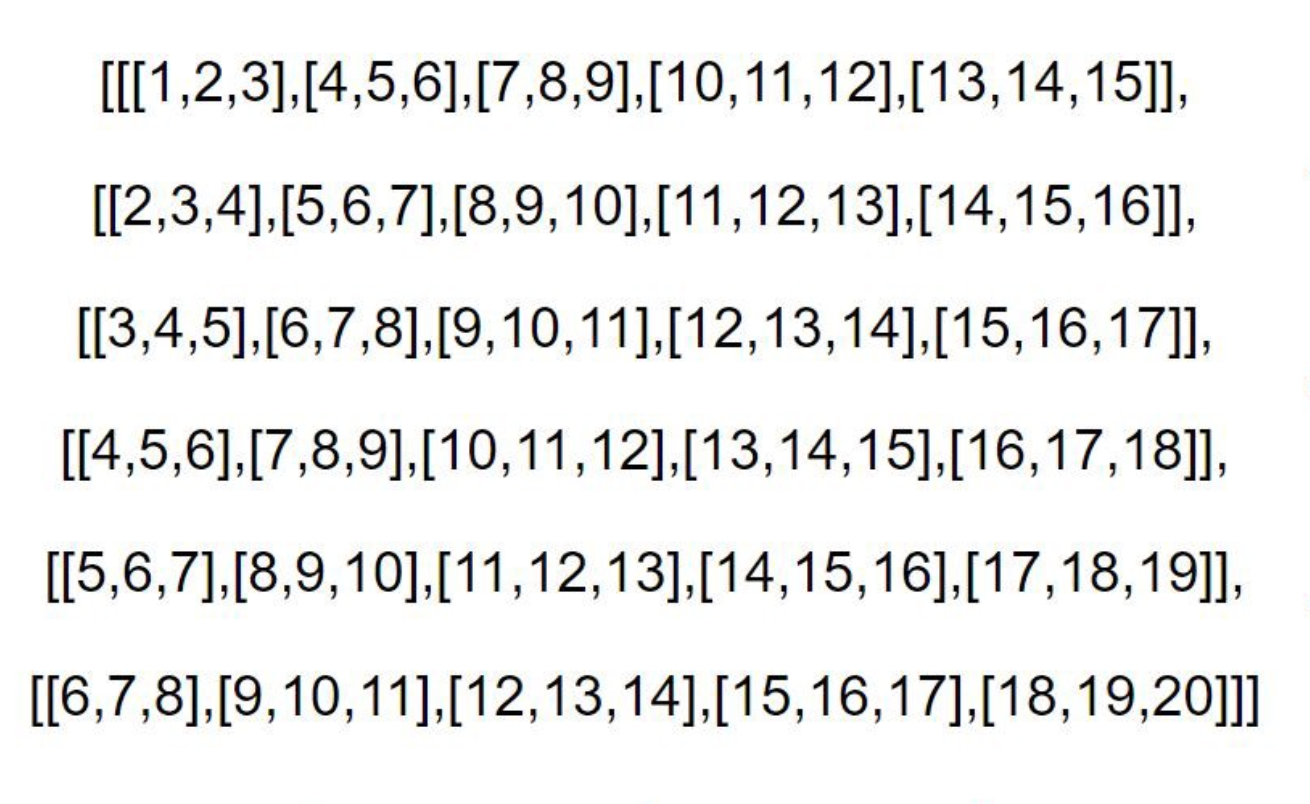

1. The initial hidden state (S), which is typically a `vector of zeros` and `the hidden state weight (h)` is multiplied and then the `hidden state bias is added` to the result.   
 - $[0, 0, 0, 0, 0, 0, 0]$  initial hidden state (S)
 - $h_wS_{initial}+h_b$  

2. input at the time step t ([1,2,3]) and the input weight (i) is multiplied and the input bias is added to that result  
 - $i_w[1,2,3]+i_b$   

3. Obtain the hidden state at time step t by sending the addition of the above two results through an activation function, typically tanh (f).  
 - Hidden state calculation of time step t
 - $S_t = (i_w[1,2,3]+i_b) + (h_wS_{initial}+h_b)$   

4. to obtain the output at time step t, the hidden state (S) at time step t is multiplied by the output weight (O) at time step t and then the output bias is added to the result.
  
 - Output calculation of time step t  
 - $ Output_t = (S_tO_w) + (O_b)$

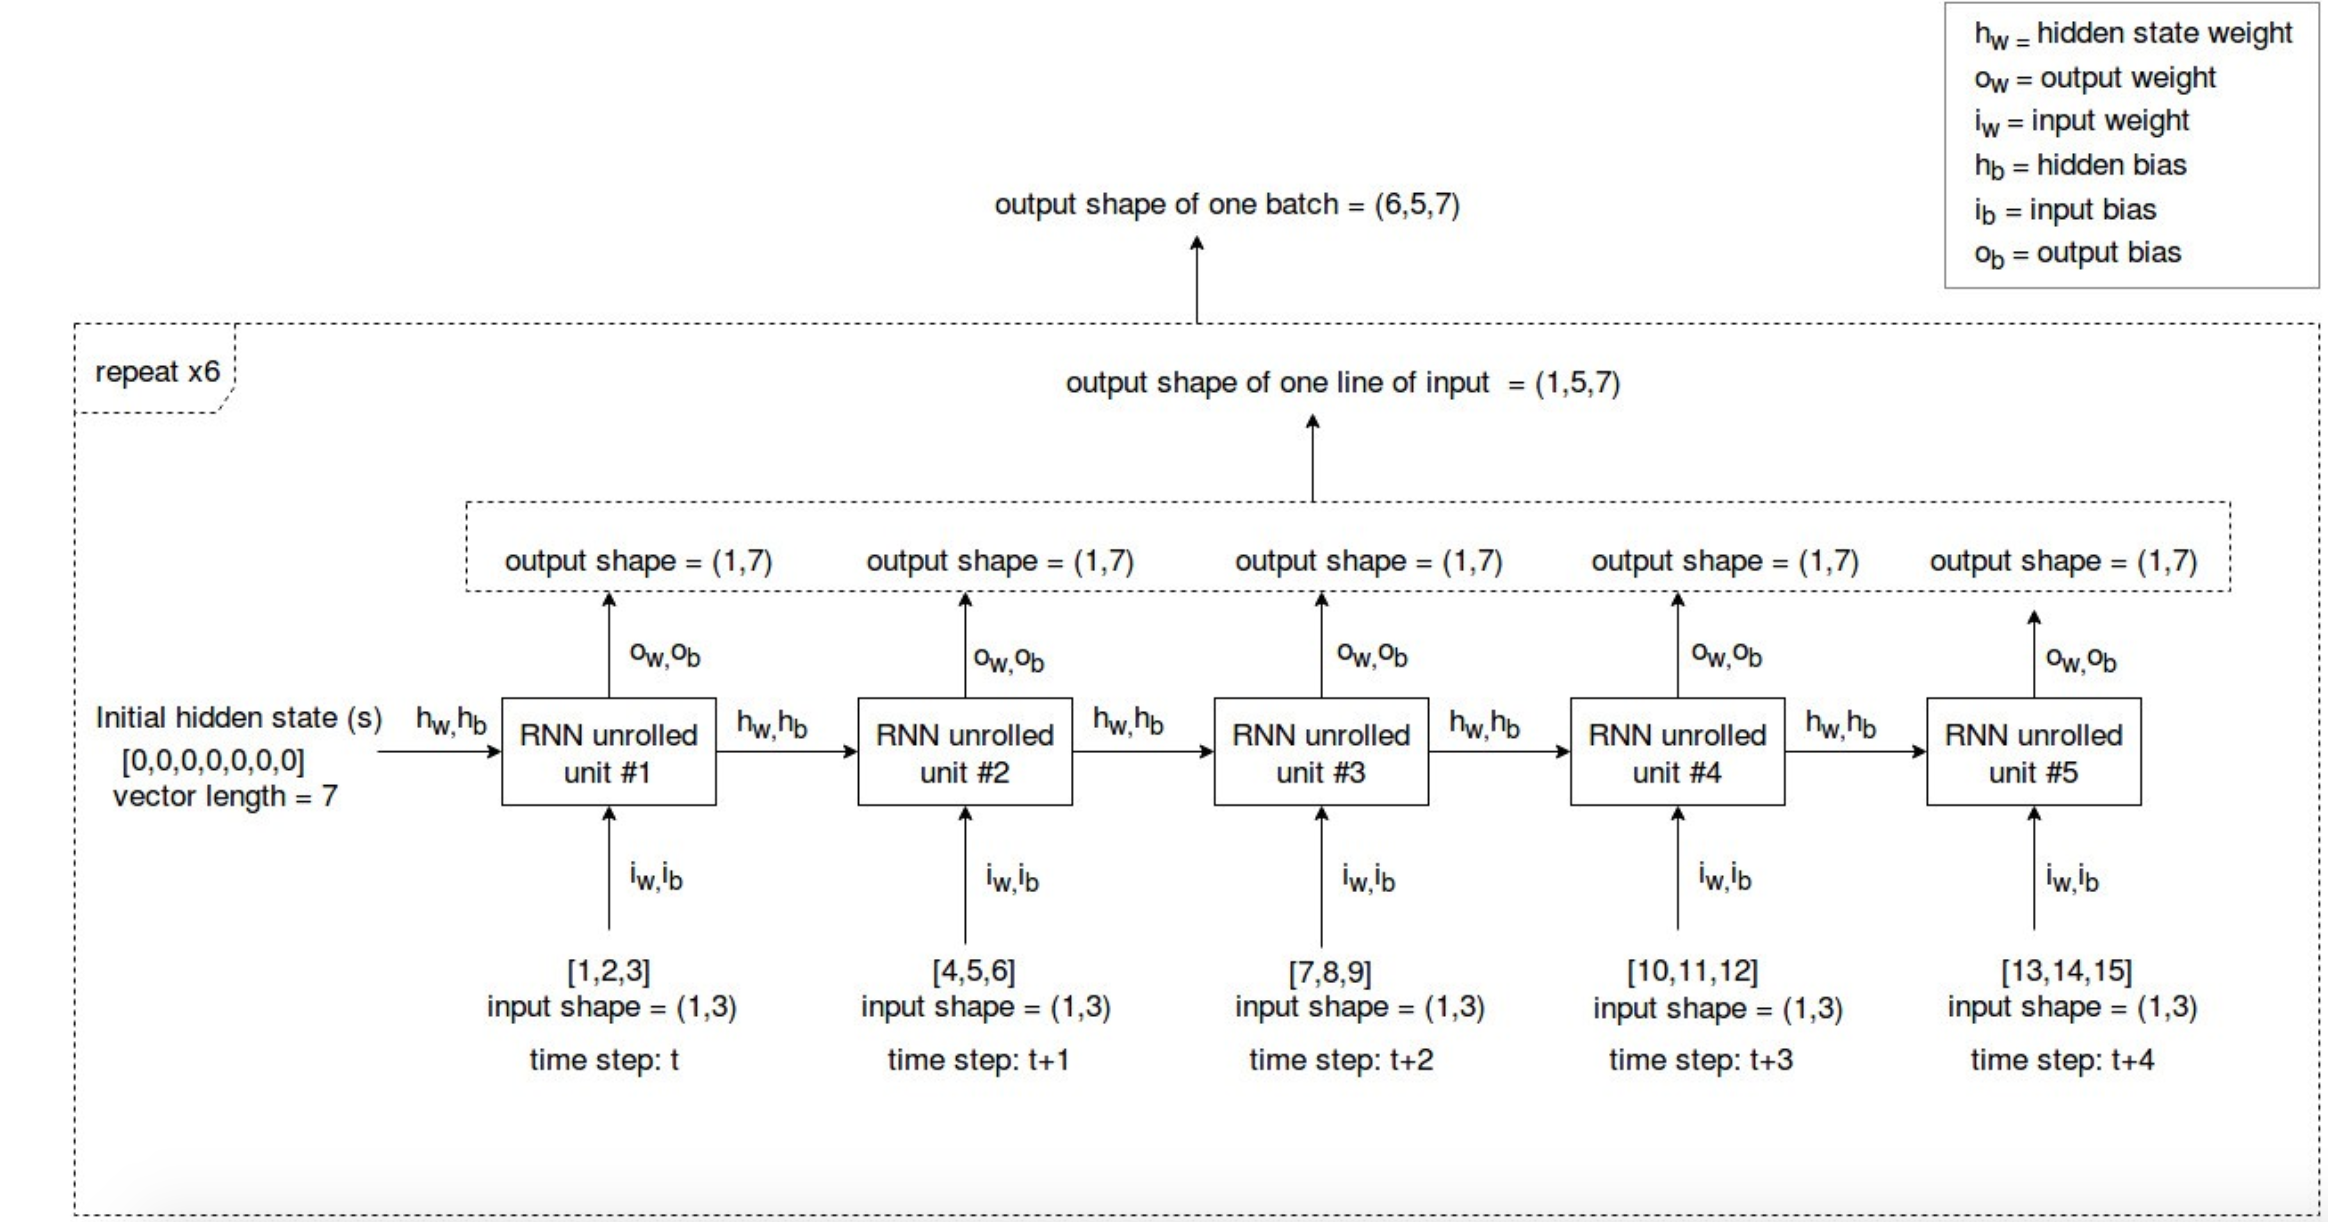

#### example simpleRNN

In [23]:
inputs1 = np.random.random([7000, 50, 1]).astype(np.float32)

In [24]:
inputs1

array([[[0.37454012],
        [0.9507143 ],
        [0.7319939 ],
        ...,
        [0.52006805],
        [0.54671025],
        [0.18485446]],

       [[0.96958464],
        [0.77513283],
        [0.93949896],
        ...,
        [0.42754102],
        [0.02541913],
        [0.10789143]],

       [[0.03142919],
        [0.6364104 ],
        [0.31435597],
        ...,
        [0.50267905],
        [0.05147875],
        [0.27864647]],

       ...,

       [[0.9867447 ],
        [0.43399608],
        [0.46048066],
        ...,
        [0.6059202 ],
        [0.2926926 ],
        [0.25436947]],

       [[0.12852685],
        [0.7028406 ],
        [0.02283508],
        ...,
        [0.8059353 ],
        [0.5695258 ],
        [0.8449741 ]],

       [[0.65570647],
        [0.52648616],
        [0.7707819 ],
        ...,
        [0.42153648],
        [0.4939706 ],
        [0.33069637]]], dtype=float32)

In [25]:
inputs1.shape

(7000, 50, 1)

In [26]:
simple_rnn1 = tf.keras.layers.SimpleRNN(1)

In [27]:
output1 = simple_rnn1(inputs1)

In [28]:
output1.shape

TensorShape([7000, 1])

In [29]:
simple_rnn2 = tf.keras.layers.SimpleRNN(
    1, input_shape=[None, 1])

In [30]:
output2 = simple_rnn2(inputs1)

In [31]:
output2.shape

TensorShape([7000, 1])

`0.010`, so it is better than the `naive approach` but it does not beat a `simple linear model`.  
 - simple linear model we used, that’s a total of `51 parameters` . 
 - RNN, total of just `three parameters`. 
  - for each recurrent neuron in a simple RNN, there is just   
    - `one parameter per input`    
    - and `per hidden state dimension`  
    (in a simple RNN, that’s just the number of recurrent neurons in the layer)  
    - plus a `bias term`

In [33]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0109


0.010881561785936356

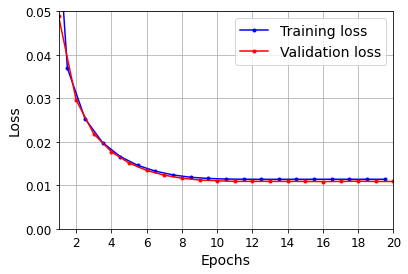

In [34]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

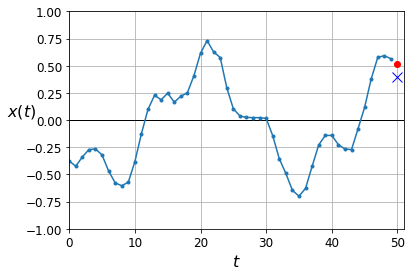

In [35]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

# Trend and Seasonality  
*** 
 -  `weighted moving average(wMA)` models or `autoregressive integrated moving average (ARIMA)` models.  
  - require you to first remove the trend and seasonality  
  - you would have to add the trend back to get the final predictions  
  - `remove this seasonality` from the time series, for example by computing the difference between the value at each time step and the value one year earlier (this technique is called `differencing`)  
  -> you would have to add the seasonal pattern back to get the final predictions.  

`RNNs`, it is generally not necessary to do all this, but it may improve performance in some cases  
<font color=gray> wMA, ARIMA 에서 계절성과 트렌드 제거 후 예측시 다시 추가해준다  
RNN 에서 꼭 필수는 아니지만 퍼포먼스를 향상시켜줄수 있다.</font>

## Deep RNNs  
***  
set<font color=pink> return_sequences=True</font> for all recurrent layers (except the last one, if you only care about the last output)  
 - If you don’t, they will output a 2D array (containing only the output of the last time step) instead of a 3D array (containing outputs for all time steps)
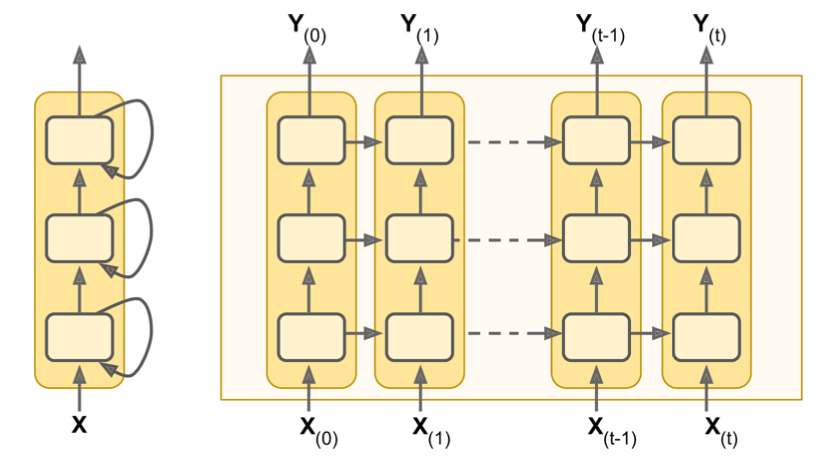

In [36]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 8s 39ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 9s 43ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 11s 48ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0035 - val_

it reaches an MSE of 0.0029. We finally managed to beat the linear model

In [37]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 7ms/step - loss: 0.0029


0.002910564187914133

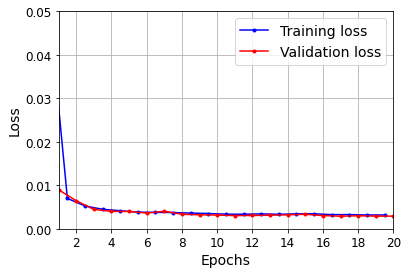

In [38]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

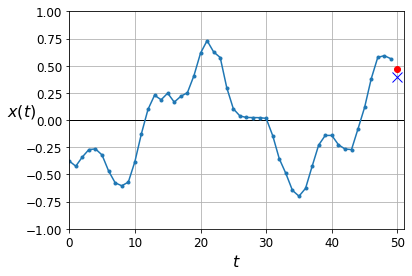

In [39]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Note that the last layer is not ideal: it must have a single unit because we want to forecast a univariate time series   
`model = keras.models.Sequential([`  
    $\qquad$ `keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),`  
    $\qquad$ `keras.layers.SimpleRNN(20, return_sequences=True),`  
    $\qquad$ `keras.layers.SimpleRNN(1)`
  
 -  it will not use the final layer’s hidden state very much
 - SimpleRNN layer uses the tanh activation function by default, the predicted values must lie within the range –1 to 1  
 - it might be preferable to replace the output layer with a <font color=pink>Dense layer</font>  
  - to use another activation function  
  - faster, the accuracy would be roughly the same  
  - make sure to <font color=pink>remove return_sequences=True</font> from the second (now last) recurrent layer  
  <font color=gray> tanh 말고 다른 활성화 함수 사용시 <font color=pink>Dense layer</font>사용,  
  <font color=pink>remove return_sequences=True</font>를 덴스레이어 전 마지막 리커런트 layer에서 제거해 줘야한다.  </font>

<br>  
Make the second `SimpleRNN` layer return only the last output:

In [40]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)    # 1 layer, keras.layers.SimpleRNN(1) 대신 Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0030 - val_lo

In [41]:
model.evaluate(X_valid, y_valid)    # 0.0026

63/63 [==============================] - 0s 7ms/step - loss: 0.0026


0.002623623702675104

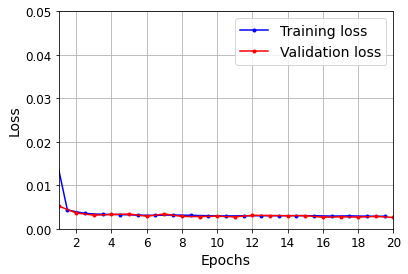

In [42]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

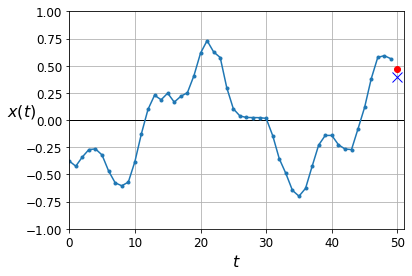

In [43]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead  
***  
#### to predict 10 steps ahead, just change the targets to be the value 10 steps ahead instead of 1 step ahead  
***  
#### 1. use the model we already trained,   
 - make it predict the next value,   
 - then add that value to the inputs  
 - and use the model again to predict the following value, and so on

In [54]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [46]:
series.shape

(1, 60, 1)

In [49]:
X_new.shape

(1, 50, 1)

In [50]:
Y_new.shape

(1, 10, 1)

In [45]:
Y_pred.shape

(1, 10, 1)

In [52]:
y_pred_one

array([[[-0.51475257]]], dtype=float32)

Saving figure forecast_ahead_plot


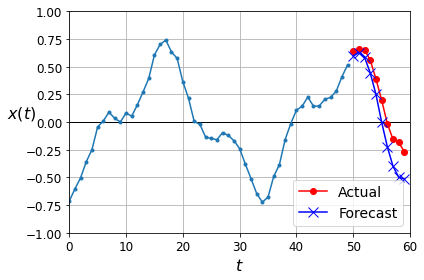

In [53]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

`naive approach` is terrible (it gives an MSE of about 0.223),   
`linear model` gives an MSE of about 0.0188:   
`RNN` MSE of about 0.029

#### 2. train an RNN to predict all 10 next values at once.  
Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.  
 - sequence-to-vector model  
 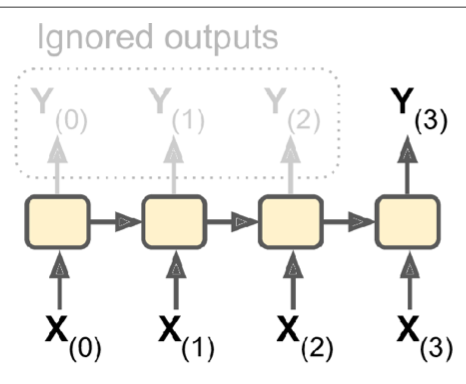

In [55]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [58]:
series.shape

(10000, 60, 1)

In [56]:
X_train.shape

(7000, 50, 1)

In [57]:
Y_train.shape

(7000, 10)

In [59]:
Y_test.shape

(1000, 10)

#### Now let's predict the next 10 values one by one:  
 - If you evaluate this approach on the validation set, you will find an MSE of about 0.029

In [60]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]
# 0~1999, 50에서 60까지 

In [61]:
Y_pred.shape

(2000, 10)

In [63]:
Y_valid.shape

(2000, 10)

In [62]:
X.shape

(2000, 60, 1)

In [65]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))
#평균 MSE 0.0275

0.027510857

#### Let's compare this performance with some baselines: `naive predictions` and a `simple linear model`:  
 - naive approach is terrible (it gives an MSE of about 0.223),  
 - but the linear model gives an MSE of about 0.0188

In [66]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848

In [67]:
Y_naive_pred.shape

(2000, 1)

In [68]:
#linear
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1343 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0234 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0227 - val_loss: 0.0222

In [86]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 8ms/step - loss: 0.0085


0.008533013984560966

In [88]:
Y_valid.shape

(2000, 10)

In [89]:
X_valid.shape

(2000, 50, 1)

#### Now let's create an `RNN that predicts all 10 next values at once`:

In [71]:
#RNN 10개 한번에
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)    # output layer to have 10 units instead of 1
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 12s 55ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 8s 39ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0110 - val_l

In [133]:
# model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 8ms/step - loss: 0.0085


0.008533013984560966

In [121]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

In [130]:
print('series', series.shape,'\n','X_new',X_new.shape,
      '\n','Y_new', Y_new.shape,'\n','Y_pred', Y_pred.shape,'\n','Y_valid', Y_valid.shape)

series (1, 60, 1) 
 X_new (1, 50, 1) 
 Y_new (1, 10, 1) 
 Y_pred (1, 10, 1) 
 Y_valid (2000, 10)


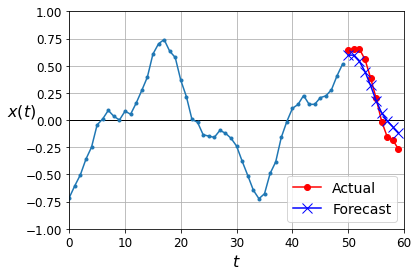

In [73]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

#### Now let's create an RNN that predicts the `next 10 steps at each time step`.   
That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49,  
 - it will forecast time steps 1 to 10 at time step 0,   
 - then time steps 2 to 11 at time step 1,   
 - and so on,   
 - and finally it will forecast time steps 50 to 59 at the last time step.   

Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [134]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

Y = np.empty((10000, n_steps, 10))    # each target is a sequence of 10D vectors
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [148]:
print('X_train', X_train.shape, 'Y_train', Y_train.shape,'\n'
      'X_valid',X_valid.shape,'Y_valid',Y_valid.shape,'\n' 
      'X_test',X_test.shape, 'Y_test',Y_test.shape,'\n' 
      'series',series.shape)

X_train (7000, 50, 1) Y_train (7000, 50, 10) 
X_valid (2000, 50, 1) Y_valid (2000, 50, 10) 
X_test (1000, 50, 1) Y_test (1000, 50, 10) 
series (10000, 60, 1)


In [162]:
# turn into sequence-to-sequence model  

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    # must set return_sequences=True in all recurrent layers (even the last one)
    
    keras.layers.TimeDistributed(keras.layers.Dense(10))
    #  TimeDistributed layer - input dimensions is 20 
    # it reshapes the inputs from [batch size, time steps, input dimensions] 
    # to [batch size × time steps, input dimensions]
    #  Dense layer - output dimensions is 10
    # reshapes the outputs from [batch size × time steps, output dimensions] 
    # to [batch size, time steps, output dimensions]
    
    #  TimeDistributed(Dense(n)) layer = a Conv1D(n, filter_size=1) layer.
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0366 - val_last_time_step_mse: 0.0264
Epoch 3/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0323 - last_time_step_mse: 0.0212 - val_loss: 0.0343 - val_last_time_step_mse: 0.0244
Epoch 4/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0297 - last_time_step_mse: 0.0186 - val_loss: 0.0284 - val_last_time_step_mse: 0.0164
Epoch 5/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0274 - last_time_step_mse: 0.0153 - val_loss: 0.0282 - val_last_time_step_mse: 0.0196
Epoch 6/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0251 - last_time_step_mse: 0.0126 - val_loss: 0.0215 - val_last_time_step_mse: 0.0081
Epoch 7/20
219/219 [==

In [164]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 7ms/step - loss: 0.0205 - last_time_step_mse: 0.0096


[0.02045186050236225, 0.009589637629687786]

In [165]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

In [166]:
print('X_new', X_new.shape, 'Y_new', Y_new.shape,'\n'
      'X_valid',X_valid.shape,'Y_valid',Y_valid.shape,'\n' 
      'Y_pred',Y_pred.shape,'\n' 
      'series',series.shape)

X_new (1, 50, 1) Y_new (1, 10, 1) 
X_valid (2000, 50, 1) Y_valid (2000, 50, 10) 
Y_pred (1, 10, 1) 
series (1, 60, 1)


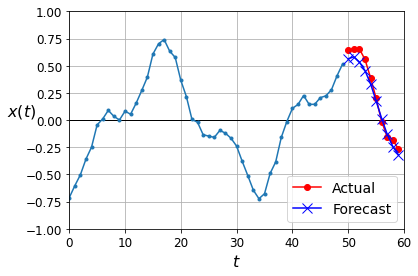

In [167]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Handling Long Sequences  
***  
## Fighting the Unstable Gradients Problem
***  
Many of the tricks we used in deep nets to alleviate the unstable gradients problem can also be used for RNNs  
 - good parameter initialization,   
 - faster optimizers,   
 - dropout,   
 - and so on  

gradients themselves can explode.   
 - If you notice that training is unstable, you may want to monitor the size of the gradients (e.g., using TensorBoard) and perhaps use Gradient Clipping.

# Deep RNN with Batch Norm  
***  
cannot be used as efficiently with RNNs.  
 - you cannot use it between time steps, only between recurrent layers.  

it is technically possible to add a BN layer to a memory cell   
 - so that it will be applied at each time step (both on the inputs for that time step and on the hidden state from the previous step  
 <br>  

<font color=green>BN was slightly beneficial only when it was applied to the inputs, not to the hidden states</font>  
 - In Keras this can be done simply by adding a Batch Normalization layer before each recurrent layer  
 -  don’t expect too much from it.

In [168]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),    # Batch Normalization layer
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),    # Batch Normalization layer
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 8s 34ms/step - loss: 0.1929 - last_time_step_mse: 0.1902 - val_loss: 0.0877 - val_last_time_step_mse: 0.0832
Epoch 2/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0537 - last_time_step_mse: 0.0449 - val_loss: 0.0549 - val_last_time_step_mse: 0.0462
Epoch 3/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0471 - last_time_step_mse: 0.0375 - val_loss: 0.0451 - val_last_time_step_mse: 0.0358
Epoch 4/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0437 - last_time_step_mse: 0.0337 - val_loss: 0.0418 - val_last_time_step_mse: 0.0314
Epoch 5/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0409 - last_time_step_mse: 0.0306 - val_loss: 0.0391 - val_last_time_step_mse: 0.0287
Epoch 6/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0385 - last_time_step_mse: 0.0275 - val_loss: 0.0379 - val_last_time_step_mse: 0.0273
Epoch 7/20
219/219 [==

# Deep RNNs with Layer Norm  
***  
Another form of normalization often works better with RNNs: Layer Normalization 
https://homl.info/layernorm  
One advantage   
 - is that it can compute the required statistics on the fly, at each time step, independently for each instance.  

<br>  
`In an RNN`, it is typically used right after the linear combination of the inputs and the hidden states  

<br> 
all recurrent layers (except for keras.layers.RNN) and all cells provided by Keras have a `dropout hyperparameter` and a `recurrent_dropout hyperparameter`  
 - former defines the dropout rate to `apply to the inputs` (at each time step)   
 - latter defines the dropout rate for the `hidden states` (also at each time step)
  - No need to create a custom cell to apply dropout at each time step in an RNN  
  - you can `alleviate` the `unstable gradients problem` and train an RNN much more efficiently

In [169]:
from tensorflow.keras.layers import LayerNormalization

In [170]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        # takes the number of units and the desired activation function,
        # and it sets the state_size and output_size attributes.
        
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        # creates a SimpleRNNCell with no activation function
        
        self.layer_norm = LayerNormalization()
        # Then the constructor creates the LayerNormaliza tion layer, 
        
        self.activation = keras.activations.get(activation)
        # and finally it fetches the desired activation function
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        # call() method starts by applying the simple RNN cell,
        # Computes a linear combination of the current inputs and the previous hidden states, 
        # and it returns the result twice.
        # outputs are just equal to the hidden states: new_states[0] = outputs
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]
        # returns the outputs twice (once as the outputs, and once as the new hidden states).

In [171]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 16s 71ms/step - loss: 0.1591 - last_time_step_mse: 0.1499 - val_loss: 0.0734 - val_last_time_step_mse: 0.0624
Epoch 2/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0638 - last_time_step_mse: 0.0505 - val_loss: 0.0566 - val_last_time_step_mse: 0.0423
Epoch 3/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0531 - last_time_step_mse: 0.0375 - val_loss: 0.0509 - val_last_time_step_mse: 0.0342
Epoch 4/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0471 - last_time_step_mse: 0.0311 - val_loss: 0.0442 - val_last_time_step_mse: 0.0286
Epoch 5/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0428 - last_time_step_mse: 0.0273 - val_loss: 0.0418 - val_last_time_step_mse: 0.0258
Epoch 6/20
219/219 [==============================] - 15s 68ms/step - loss: 0.0395 - last_time_step_mse: 0.0243 - val_loss: 0.0382 - val_last_time_step_mse: 0.0229
Epoch 7/20
219/2

# Creating a Custom RNN Class

In [172]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        return [tf.zeros([self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        n_steps = tf.shape(inputs)[1]
        if self.return_sequences:
            sequences = tf.TensorArray(inputs.dtype, size=n_steps)
        outputs = tf.zeros(shape=[n_steps, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return sequences.stack()
        else:
            return outputs

In [173]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 15s 68ms/step - loss: 0.2101 - last_time_step_mse: 0.2091 - val_loss: 0.0792 - val_last_time_step_mse: 0.0749
Epoch 2/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0704 - last_time_step_mse: 0.0639 - val_loss: 0.0638 - val_last_time_step_mse: 0.0570
Epoch 3/20
219/219 [==============================] - 16s 72ms/step - loss: 0.0590 - last_time_step_mse: 0.0503 - val_loss: 0.0546 - val_last_time_step_mse: 0.0432
Epoch 4/20
219/219 [==============================] - 15s 70ms/step - loss: 0.0518 - last_time_step_mse: 0.0402 - val_loss: 0.0491 - val_last_time_step_mse: 0.0372
Epoch 5/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0472 - last_time_step_mse: 0.0354 - val_loss: 0.0455 - val_last_time_step_mse: 0.0338
Epoch 6/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0433 - last_time_step_mse: 0.0312 - val_loss: 0.0411 - val_last_time_step_mse: 0.0280
Epoch 7/20
219/2

# Tackling the Short-Term Memory Problem  
***  
some information is lost at each time step. After a while, the RNN’s state contains vir‐ tually no trace of the first inputs

# LSTMs  
***  
The Long Short-Term Memory (LSTM) cell   
1997 https://www.mitpressjournals.org/doi/abs/10.1162/neco.1997.9.8.1735  
***  
In Keras, you can simply use the LSTM layer instead of the SimpleRNN layer:  
 - However, the LSTM layer uses an optimized implementation when running on a GPU <font color=green>(see Chapter 19)</font>    
 - $h_{(t)}$ as the short-term state  
 - $c_{(t)}$ as the long-term state.  
 - `forget gate`, dropping some memories, and then it adds some new memories via the addition operation (which adds the memories that were selected by an input gate).   
 - The result c(t) is sent straight out, 
 - At each time step, some memories are dropped and some memories are added.  
 - `long-term state` is copied and passed through the tanh function, and then the result is filtered by the *`output gate`*  
 - This produces the short-term state $h_{(t)}$ (which is equal to the cell’s output for this time step, $y_{(t)}$  
<br>
 - current input vector $x_{(t)}$ and the previous short-term state $h_{(t–1)}$ are fed to four different fully connected layers.  
  - The main layer is the one that outputs $g_{(t)}$.  
    - analyzing the current inputs $x_{(t)}$ and the previous (short-term) state $h_{(t–1)}$  
 - The three other layers are *`gate controllers`*.  
  - they use the logistic activation function, their outputs range from 0 to 1  
  - `The forget gate` (controlled by $f_{(t)}$) : controls which parts of the long-term state should be erased. 
  - `The input gate` (controlled by $i_{(t)}$) : controls which parts of $g_{(t)}$ should be added to the long-term state.  
  - `output gate` (controlled by $o_{(t)}$) : controls which parts of the long-term state should be read and output at this time step, both to $h_{(t)}$ and to $y_{(t)}$
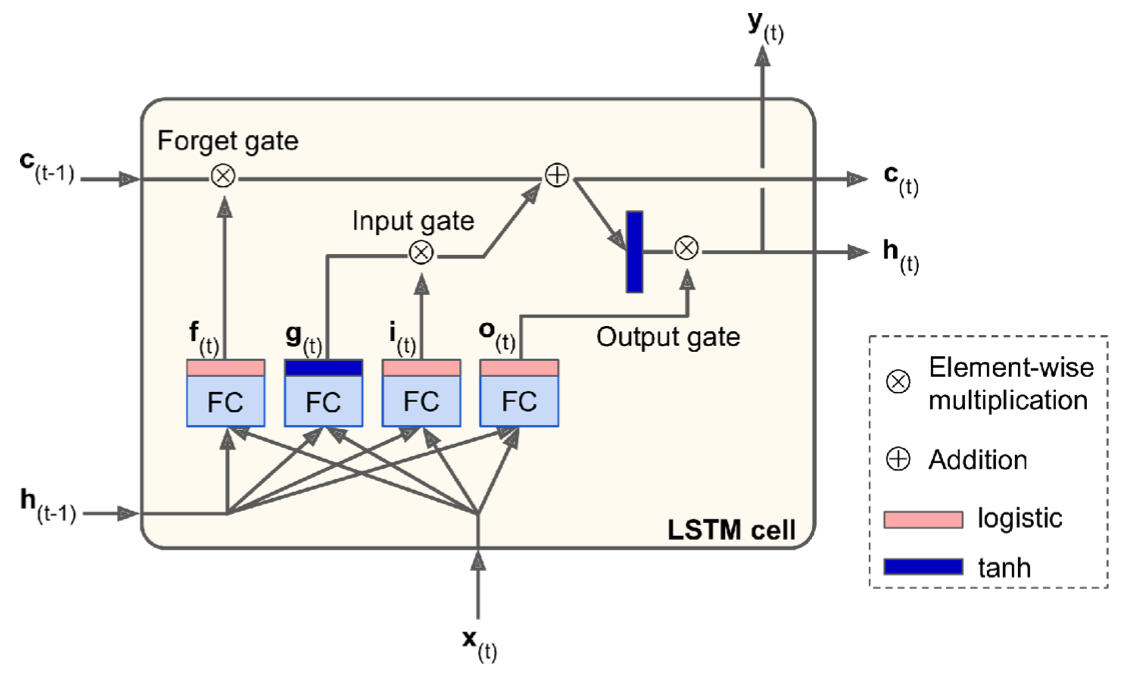  
 

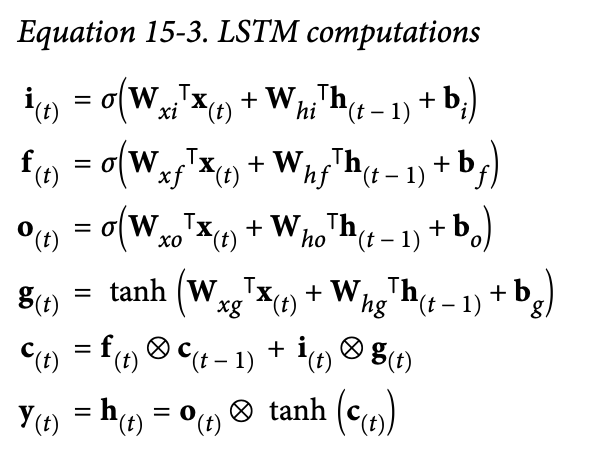

In [174]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 15s 68ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 16s 73ms/step - loss: 0.0480 - last_time_step_mse: 0.0283 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 14s 62ms/step - loss: 0.0391 - last_time_step_mse: 0.0181 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 13s 59ms/step - loss: 0.0325 - last_time_step_mse: 0.0133 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 13s 58ms/step - loss: 0.0308 - last_time_step_mse: 0.0122 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/2

In [175]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 15ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788681253790855, 0.00856079813092947]

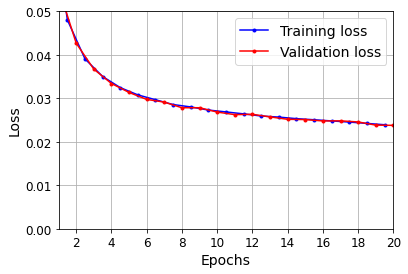

In [176]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [177]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

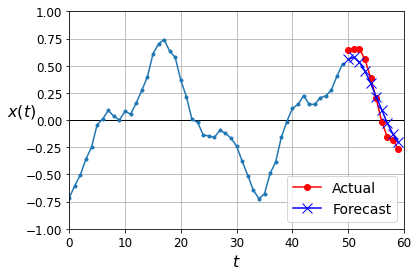

In [178]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Peephole connections  
***  
In a regular LSTM cell, gate controllers can look only at the input $x_{(t)}$ and the previous short-term state $h_{(t–1)}$  
2000 https://ieeexplore.ieee.org/abstract/document/861302  
***  
proposed an LSTM variant with extra connections called peephole connections  
 - previous long-term state $c_{(t–1)}$ is added as an input to the controllers of the `forget gate` and the `input gate`, and the `current longterm state` $c_{(t)}$ is added as input to the controller of the `output gate`.  
 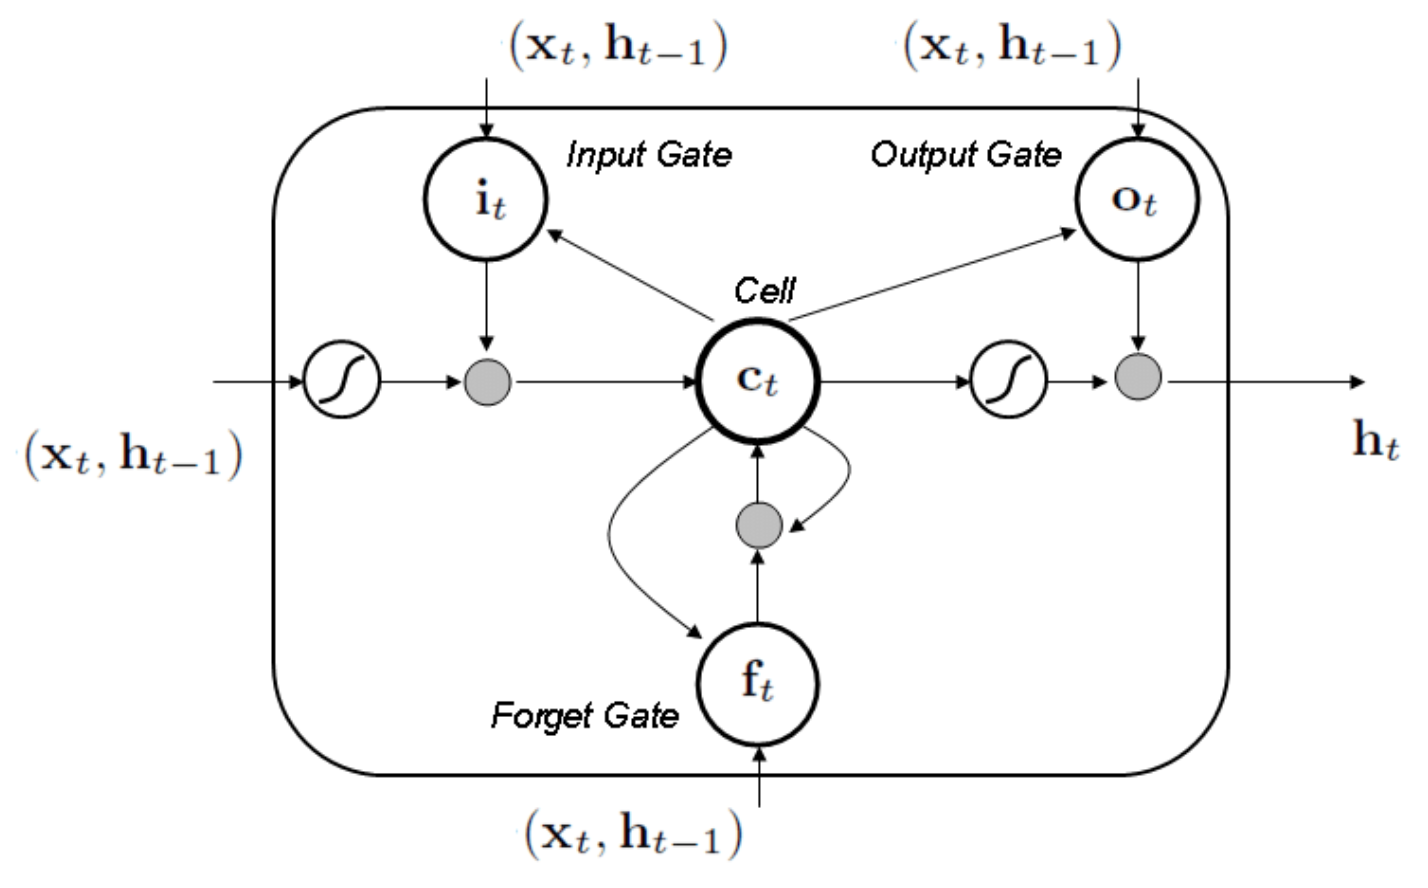  
  
In Keras, the LSTM layer is based on the <font color=pink>keras.layers.LSTMCell</font> cell, which does not support peepholes.   
 - The experimental <font color=pink>tf.keras.experimental.PeepholeLSTMCell</font> does, however, so you can create a <font color=pink>keras.layers.RNN</font> layer and pass a PeepholeLSTM Cell to its constructor.

# GRUs  
***  
2014 https://arxiv.org/abs/1406.1078  
***  
that also introduced the Encoder–Decoder network  
GRU cell is a simplified version of the LSTM cell,  
 - Both state vectors are merged into a single vector$ h_{(t)}$.  
 - A single gate controller $z_{(t)}$ controls both the forget gate and the input gate.  
  the forget gate is open (= 1)  
  input gate is closed (1 – 1 = 0)  
 - There is no output gate; the full state vector is output at every time step.   
 there is a new gate controller $r_{(t)}$ that controls which part of the previous state will be shown to the main layer $(g_{(t)})$.
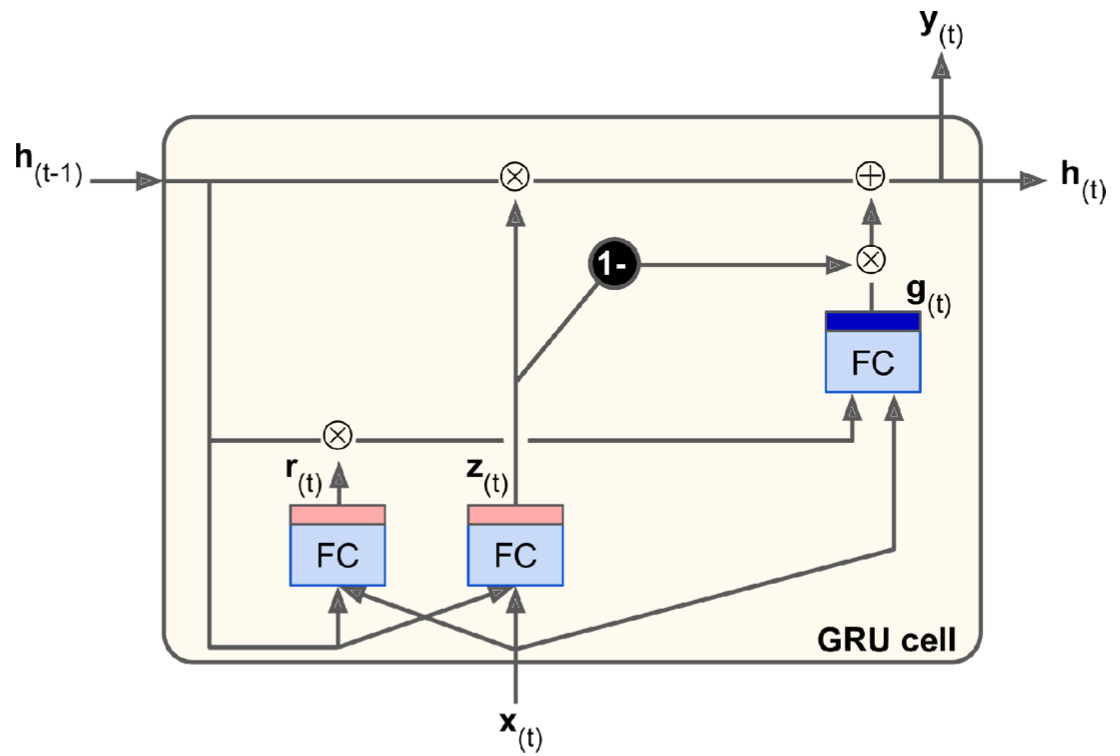  
  


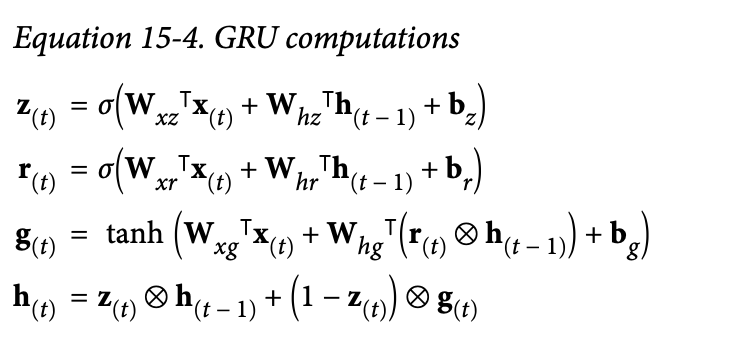  
Keras provides a <font color=pink>keras.layers.GRU</font> layer (based on the keras.layers.GRUCellmemory cell)  

In [179]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 19s 88ms/step - loss: 0.0738 - last_time_step_mse: 0.0655 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 15s 66ms/step - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 15s 71ms/step - loss: 0.0417 - last_time_step_mse: 0.0301 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 19s 86ms/step - loss: 0.0368 - last_time_step_mse: 0.0243 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 17s 78ms/step - loss: 0.0326 - last_time_step_mse: 0.0180 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 16s 73ms/step - loss: 0.0306 - last_time_step_mse: 0.0155 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/2

In [180]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 13ms/step - loss: 0.0238 - last_time_step_mse: 0.0103


[0.023785505443811417, 0.010262809693813324]

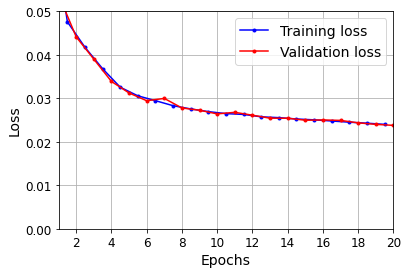

In [181]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [182]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

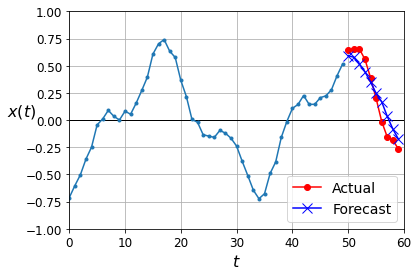

In [183]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Using One-Dimensional Convolutional Layers to Process Sequences  
***  
<br>
they still have a fairly limited short-term memory, and they have a hard time learning long-term patterns in sequences of 100 time steps or more,  
 
 - One way to solve this is to shorten the input sequences, for example `using 1D convolutional layers`.  
  - Similarly, a 1D convolutional layer slides several kernels across a sequence, producing a 1D feature map per kernel.  
  - Each kernel will learn to detect a single very short sequential pattern (no longer than the kernel size)  
  - If you use 10 kernels, then the layer’s output will be composed of 10 1-dimensional sequences.  
  -> you can view this output as a single 10-dimensional sequence  
  - If you use a `1D convolutional layer` with a `stride of 1` and `"same" padding`, then the output sequence will have the `same length` as the input sequence  
    - But if you use `"valid" paddin`g or a `stride greater than 1`, then the output sequence will be `shorter than` the input sequence, 
    

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [184]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 10s 45ms/step - loss: 0.0681 - last_time_step_mse: 0.0601 - val_loss: 0.0477 - val_last_time_step_mse: 0.0396
Epoch 2/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0414 - last_time_step_mse: 0.0340 - val_loss: 0.0367 - val_last_time_step_mse: 0.0285
Epoch 3/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0338 - last_time_step_mse: 0.0257 - val_loss: 0.0307 - val_last_time_step_mse: 0.0218
Epoch 4/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0282 - last_time_step_mse: 0.0184 - val_loss: 0.0259 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0249 - last_time_step_mse: 0.0143 - val_loss: 0.0246 - val_last_time_step_mse: 0.0141
Epoch 6/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0234 - last_time_step_mse: 0.0125 - val_loss: 0.0227 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219 [=

In [186]:
model.evaluate(X_valid, Y_valid[:, 3::2])

63/63 [==============================] - 1s 9ms/step - loss: 0.0184 - last_time_step_mse: 0.0080


[0.018366213887929916, 0.007968204095959663]

## WaveNet  
***  
2016 https://arxiv.org/abs/1609.03499  
***  
They stacked 1D convolutional layers, doubling the dilation rate (how spread apart each neuron’s inputs are) at every layer  
 - `first convolutional layer` gets a glimpse of just `two time steps` at a time,   
 - while the `next one` sees `four time steps` (its receptive field is four time steps long),  
 - the `next one` sees `eight time steps`,   
 - and so on    
<br>   
lower layers learn short-term patterns,  
higher layers learn long-term patterns.  
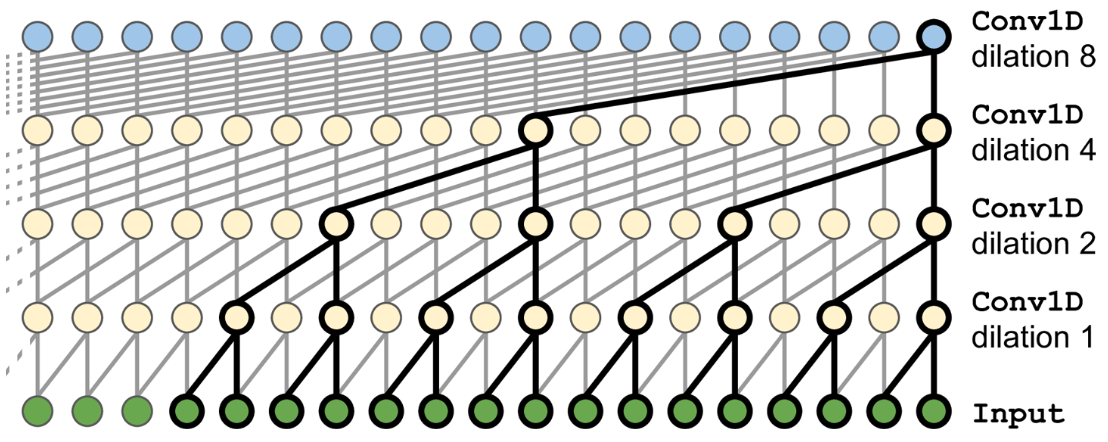  
 
 - stacked 10 convolutional layers with dilation rates of 1, 2, 4, 8, ..., 256, 512,   
 - then they stacked another group of 10 identical layers (also with dilation rates 1, 2, 4, 8, ..., 256, 512),   
 - then again another identical group of 10 layers.

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [187]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))

for rate in (1, 2, 4, 8) * 2:
# similar pairs of layers using growing dilation rates: 1, 2, 4, 8, and again 1, 2, 4, 8.
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
    # continues with a 1D convolutional layer using "causal" padding  
    # ensures that the convolutional layer does not peek into the future when making predictions
    # equivalent to padding the inputs with the right amount of zeros on the left and using "valid" padding
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
# add output layer: convolutional layer with 10 filters of size 1, without any activation function

# Thanks to the padding layers, every convolutional layer outputs 
# a sequence of the same length as the input sequences

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0669 - last_time_step_mse: 0.0543 - val_loss: 0.0365 - val_last_time_step_mse: 0.0231
Epoch 2/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0324 - last_time_step_mse: 0.0193 - val_loss: 0.0295 - val_last_time_step_mse: 0.0167
Epoch 3/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0283 - last_time_step_mse: 0.0156 - val_loss: 0.0269 - val_last_time_step_mse: 0.0145
Epoch 4/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0261 - last_time_step_mse: 0.0136 - val_loss: 0.0255 - val_last_time_step_mse: 0.0131
Epoch 5/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0248 - last_time_step_mse: 0.0125 - val_loss: 0.0245 - val_last_time_step_mse: 0.0123
Epoch 6/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0240 - last_time_step_mse: 0.0118 - val_loss: 0.0233 - val_last_time_step_mse: 0.0108
Epoch 7/20
219/219 [==

Here is the` original WaveNet` defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [59]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [60]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [61]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [62]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/2
7000/7000 [==============================] - 3s 443us/sample - loss: 0.1299 - last_time_step_mse: 0.1258 - val_loss: 0.1229 - val_last_time_step_mse: 0.1199
Epoch 2/2
7000/7000 [==============================] - 2s 271us/sample - loss: 0.1222 - last_time_step_mse: 0.1178 - val_loss: 0.1218 - val_last_time_step_mse: 0.1190


In this chapter we explored the fundamentals of RNNs and used them to process sequences (namely, time series). In the process we also looked at other ways to process sequences, including CNNs. In the next chapter we will use RNNs for Natural Language Processing, and we will learn more about RNNs (bidirectional RNNs, stateful vs stateless RNNs, Encoder–Decoders, and Attention-augmented Encoder-Decoders). We will also look at the Transformer, an Attention-only architecture.

# Exercise solutions  
***

## 1. to 8.

See Appendix A.

## 9. Tackling the SketchRNN Dataset

_Exercise: Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets._

The dataset is not available in TFDS yet, the [pull request](https://github.com/tensorflow/datasets/pull/361) is still work in progress. Luckily, the data is conveniently available as TFRecords, so let's download it (it might take a while, as it's about 1 GB large, with 3,450,000 training sketches and 345,000 test sketches):

In [63]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

In [64]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [65]:
train_files

['/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00000-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00001-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00002-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00003-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00004-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00005-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00006-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00007-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00008-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00009-of-00010']

In [66]:
eval_files

['/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00000-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00001-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00002-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00003-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00004-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00005-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00006-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00007-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00008-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00009-of-00010']

In [67]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [68]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [69]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [70]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [71]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [72]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [73]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.07058823  0.04255319  0.        ]
  [-0.01568627  0.0425532   0.        ]
  [-0.09803921  0.03191489  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.07058824  0.27741933  0.        ]
  [-0.02745098  0.06451613  0.        ]
  [-0.02352941  0.          0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.17857143  0.06666667  0.        ]
  [-0.26020408  0.15294117  0.        ]
  [-0.01020408  0.01568627  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[ 0.03056769 -0.01176471  0.        ]
  [ 0.29694325  0.          0.        ]
  [ 0.38864627  0.04705882  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

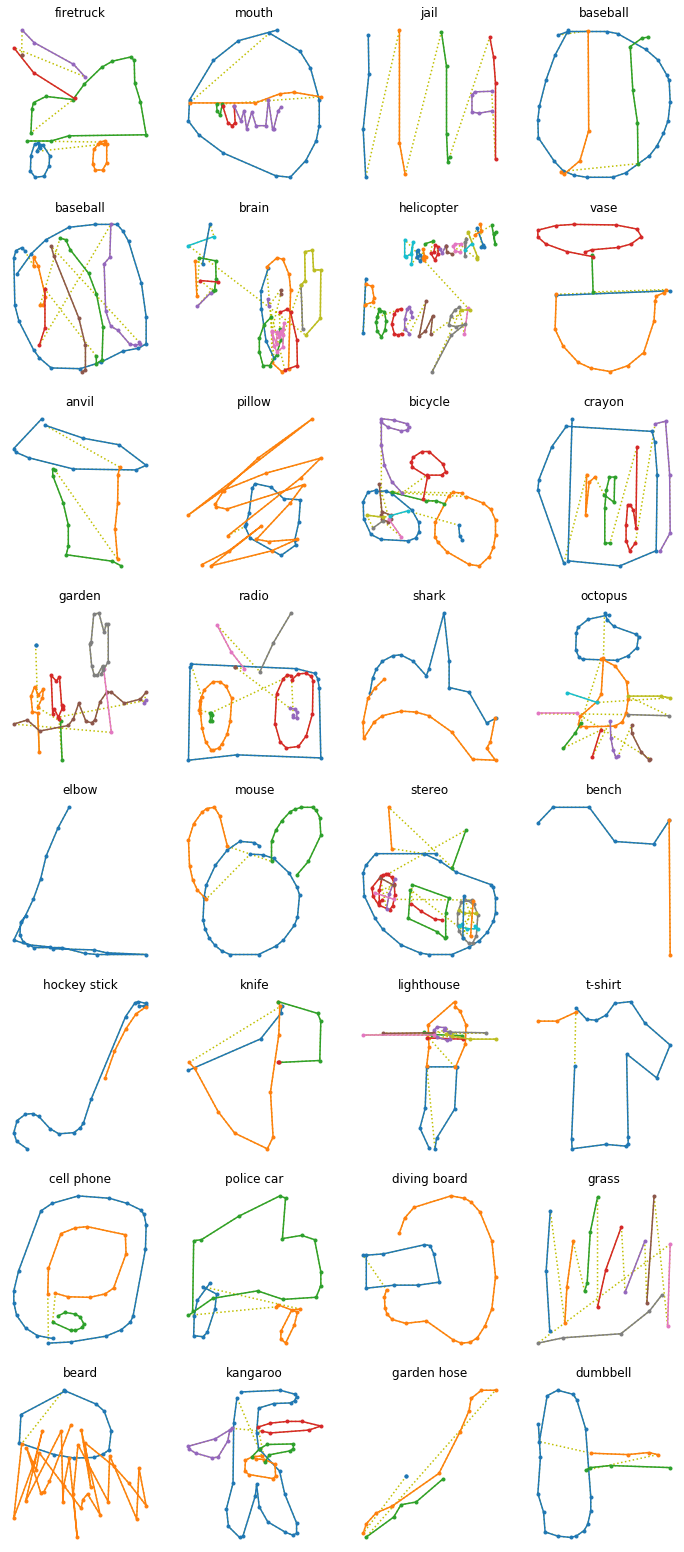

In [74]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

Most sketches are composed of less than 100 points:

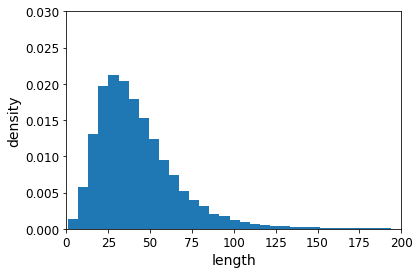

In [75]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [76]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [77]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2
107813/107813 [==============================] - 2182s 20ms/step - loss: 3.8473 - accuracy: 0.2086 - sparse_top_k_categorical_accuracy: 0.4242 - val_loss: 2.6672 - val_accuracy: 0.3872 - val_sparse_top_k_categorical_accuracy: 0.6771
Epoch 2/2
107813/107813 [==============================] - 2049s 19ms/step - loss: 2.3393 - accuracy: 0.4502 - sparse_top_k_categorical_accuracy: 0.7367 - val_loss: 2.1072 - val_accuracy: 0.4968 - val_sparse_top_k_categorical_accuracy: 0.7759


In [78]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

In [79]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.6899671

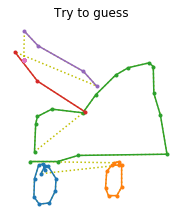

Top-5 predictions:
  1. firetruck 46.565%
  2. police car 30.455%
  3. ambulance 3.810%
  4. car 3.695%
  5. cannon 3.371%
Answer: firetruck


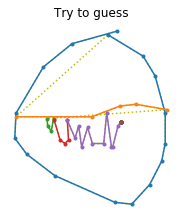

Top-5 predictions:
  1. mouth 23.162%
  2. pond 14.151%
  3. pool 12.582%
  4. beard 11.375%
  5. goatee 9.808%
Answer: mouth


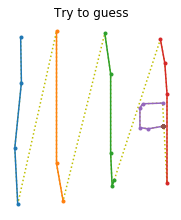

Top-5 predictions:
  1. jail 71.532%
  2. fence 6.519%
  3. swing set 5.708%
  4. grass 3.302%
  5. rain 3.023%
Answer: jail


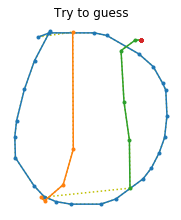

Top-5 predictions:
  1. baseball 79.233%
  2. watermelon 7.687%
  3. basketball 5.259%
  4. clock 1.659%
  5. compass 1.101%
Answer: baseball


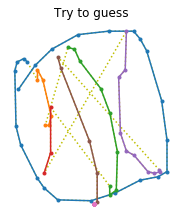

Top-5 predictions:
  1. basketball 51.888%
  2. baseball 17.328%
  3. onion 12.688%
  4. watermelon 9.989%
  5. brain 2.216%
Answer: baseball


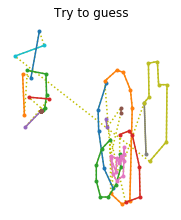

Top-5 predictions:
  1. lantern 7.235%
  2. toothpaste 6.845%
  3. drill 6.254%
  4. lighthouse 4.624%
  5. crayon 3.566%
Answer: brain


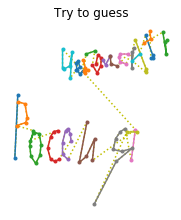

Top-5 predictions:
  1. animal migration 8.771%
  2. blackberry 7.932%
  3. blueberry 6.413%
  4. peas 5.549%
  5. bracelet 3.623%
Answer: helicopter


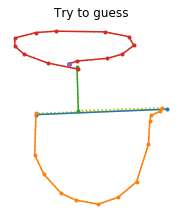

Top-5 predictions:
  1. vase 42.793%
  2. wine glass 13.744%
  3. shovel 8.136%
  4. house plant 5.144%
  5. sailboat 4.850%
Answer: vase


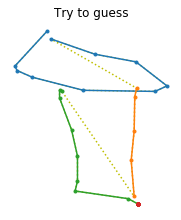

Top-5 predictions:
  1. anvil 25.870%
  2. drill 9.670%
  3. nail 7.246%
  4. screwdriver 5.611%
  5. knee 4.355%
Answer: anvil


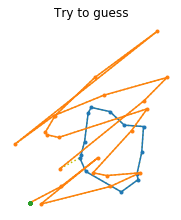

Top-5 predictions:
  1. hurricane 34.674%
  2. tornado 16.056%
  3. blackberry 7.664%
  4. squiggle 5.489%
  5. zigzag 4.906%
Answer: pillow


In [80]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [81]:
model.save("my_sketchrnn")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_sketchrnn/assets


## 10. Bach Chorales
_Exercise: Download the [Bach chorales](https://homl.info/bach) dataset and unzip it. It is composed of 382 chorales composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long, and each time step contains 4 integers, where each integer corresponds to a note's index on a piano (except for the value 0, which means that no note is played). Train a model—recurrent, convolutional, or both—that can predict the next time step (four notes), given a sequence of time steps from a chorale. Then use this model to generate Bach-like music, one note at a time: you can do this by giving the model the start of a chorale and asking it to predict the next time step, then appending these time steps to the input sequence and asking the model for the next note, and so on. Also make sure to check out [Google's Coconet model](https://homl.info/coconet), which was used for a nice [Google doodle about Bach](https://www.google.com/doodles/celebrating-johann-sebastian-bach)._



In [82]:
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/datasets/jsb_chorales/"
FILENAME = "jsb_chorales.tgz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/jsb_chorales",
                                extract=True)

In [83]:
jsb_chorales_dir = Path(filepath).parent
train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

In [84]:
import pandas as pd

def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

In [85]:
train_chorales[0]

[[74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [75, 70, 58, 55],
 [75, 70, 58, 55],
 [75, 70, 60, 55],
 [75, 70, 60, 55],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 70, 62, 55],
 [77, 70, 62, 55],
 [77, 69, 62, 55],
 [77, 69, 62, 55],
 [75, 67, 63, 48],
 [75, 67, 63, 48],
 [75, 69, 63, 48],
 [75, 69, 63, 48],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [75, 69, 63, 48],
 [75, 69, 63, 48],
 [75, 67, 63, 48],
 [75, 67, 63, 48],
 [77, 65, 62, 50],
 [77, 65, 62, 50],
 [77, 65, 60, 50],
 [77, 65, 60, 50],
 [74, 67, 58, 55],
 [74, 67, 58, 55],
 [74, 67, 58, 53],
 [74, 67, 58, 53],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 65, 57

Notes range from 36 (C1 = C on octave 1) to 81 (A5 = A on octave 5), plus 0 for silence:

In [86]:
notes = set()
for chorales in (train_chorales, valid_chorales, test_chorales):
    for chorale in chorales:
        for chord in chorale:
            notes |= set(chord)

n_notes = len(notes)
min_note = min(notes - {0})
max_note = max(notes)

assert min_note == 36
assert max_note == 81

Let's write a few functions to listen to these chorales (you don't need to understand the details here, and in fact there are certainly simpler ways to do this, for example using MIDI players, but I just wanted to have a bit of fun writing a synthesizer):

In [87]:
from IPython.display import Audio

def notes_to_frequencies(notes):
    # Frequency doubles when you go up one octave; there are 12 semi-tones
    # per octave; Note A on octave 4 is 440 Hz, and it is note number 69.
    return 2 ** ((np.array(notes) - 69) / 12) * 440

def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo # the tempo is measured in beats per minutes
    # To reduce click sound at every beat, we round the frequencies to try to
    # get the samples close to zero at the end of each note.
    frequencies = np.round(note_duration * frequencies) / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    # Removing all notes with frequencies ≤ 9 Hz (includes note 0 = silence)
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = np.r_[freqs, freqs[-1:]] # make last note a bit longer
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate)
                     for melody in freqs.T], axis=0)
    n_fade_out_samples = sample_rate * 60 // tempo # fade out last note
    fade_out = np.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

def play_chords(chords, tempo=160, amplitude=0.1, sample_rate=44100, filepath=None):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    if filepath:
        from scipy.io import wavfile
        samples = (2**15 * samples).astype(np.int16)
        wavfile.write(filepath, sample_rate, samples)
        return display(Audio(filepath))
    else:
        return display(Audio(samples, rate=sample_rate))

Now let's listen to a few chorales:

In [88]:
for index in range(3):
    play_chords(train_chorales[index])

Divine! :)

In order to be able to generate new chorales, we want to train a model that can predict the next chord given all the previous chords. If we naively try to predict the next chord in one shot, predicting all 4 notes at once, we run the risk of getting notes that don't go very well together (believe me, I tried). It's much better and simpler to predict one note at a time. So we will need to preprocess every chorale, turning each chord into an arpegio (i.e., a sequence of notes rather than notes played simultaneuously). So each chorale will be a long sequence of notes (rather than chords), and we can just train a model that can predict the next note given all the previous notes. We will use a sequence-to-sequence approach, where we feed a window to the neural net, and it tries to predict that same window shifted one time step into the future.

We will also shift the values so that they range from 0 to 46, where 0 represents silence, and values 1 to 46 represent notes 36 (C1) to 81 (A5).

And we will train the model on windows of 128 notes (i.e., 32 chords).

Since the dataset fits in memory, we could preprocess the chorales in RAM using any Python code we like, but I will demonstrate here how to do all the preprocessing using tf.data (there will be more details about creating windows using tf.data in the next chapter).

In [89]:
def create_target(batch):
    X = batch[:, :-1]
    Y = batch[:, 1:] # predict next note in each arpegio, at each step
    return X, Y

def preprocess(window):
    window = tf.where(window == 0, window, window - min_note + 1) # shift values
    return tf.reshape(window, [-1]) # convert to arpegio

def bach_dataset(chorales, batch_size=32, shuffle_buffer_size=None,
                 window_size=32, window_shift=16, cache=True):
    def batch_window(window):
        return window.batch(window_size + 1)

    def to_windows(chorale):
        dataset = tf.data.Dataset.from_tensor_slices(chorale)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder=True)
        return dataset.flat_map(batch_window)

    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.flat_map(to_windows).map(preprocess)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(create_target)
    return dataset.prefetch(1)

Now let's create the training set, the validation set and the test set:

In [90]:
train_set = bach_dataset(train_chorales, shuffle_buffer_size=1000)
valid_set = bach_dataset(valid_chorales)
test_set = bach_dataset(test_chorales)

Now let's create the model:

* We could feed the note values directly to the model, as floats, but this would probably not give good results. Indeed, the relationships between notes are not that simple: for example, if you replace a C3 with a C4, the melody will still sound fine, even though these notes are 12 semi-tones apart (i.e., one octave). Conversely, if you replace a C3 with a C\#3, it's very likely that the chord will sound horrible, despite these notes being just next to each other. So we will use an `Embedding` layer to convert each note to a small vector representation (see Chapter 16 for more details on embeddings). We will use 5-dimensional embeddings, so the output of this first layer will have a shape of `[batch_size, window_size, 5]`.
* We will then feed this data to a small WaveNet-like neural network, composed of a stack of 4 `Conv1D` layers with doubling dilation rates. We will intersperse these layers with `BatchNormalization` layers for faster better convergence.
* Then one `LSTM` layer to try to capture long-term patterns.
* And finally a `Dense` layer to produce the final note probabilities. It will predict one probability for each chorale in the batch, for each time step, and for each possible note (including silence). So the output shape will be `[batch_size, window_size, 47]`.

In [91]:
n_embedding_dims = 5

model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.Dense(n_notes, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 5)           235       
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          352       
_________________________________________________________________
batch_normalization (BatchNo (None, None, 32)          128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 48)          3120      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 48)          192       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          6208      
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 64)          2

Now we're ready to compile and train the model!

In [92]:
optimizer = keras.optimizers.Nadam(lr=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.fit(train_set, epochs=20, validation_data=valid_set)

Epoch 1/20
98/98 [==============================] - 17s 171ms/step - loss: 1.8198 - accuracy: 0.5358 - val_loss: 3.7675 - val_accuracy: 0.0428
Epoch 2/20
98/98 [==============================] - 15s 152ms/step - loss: 0.8885 - accuracy: 0.7641 - val_loss: 4.1054 - val_accuracy: 0.0470
Epoch 3/20
98/98 [==============================] - 16s 165ms/step - loss: 0.7471 - accuracy: 0.7930 - val_loss: 3.8600 - val_accuracy: 0.0368
Epoch 4/20
98/98 [==============================] - 16s 165ms/step - loss: 0.6749 - accuracy: 0.8083 - val_loss: 3.0490 - val_accuracy: 0.2196
Epoch 5/20
98/98 [==============================] - 15s 157ms/step - loss: 0.6221 - accuracy: 0.8188 - val_loss: 1.7138 - val_accuracy: 0.5153
Epoch 6/20
98/98 [==============================] - 16s 163ms/step - loss: 0.5833 - accuracy: 0.8283 - val_loss: 1.9068 - val_accuracy: 0.4570
Epoch 7/20
98/98 [==============================] - 16s 165ms/step - loss: 0.5484 - accuracy: 0.8362 - val_loss: 0.7930 - val_accuracy: 0.7678

I have not done much hyperparameter search, so feel free to iterate on this model now and try to optimize it. For example, you could try removing the `LSTM` layer and replacing it with `Conv1D` layers. You could also play with the number of layers, the learning rate, the optimizer, and so on.

Once you're satisfied with the performance of the model on the validation set, you can save it and evaluate it one last time on the test set:

In [93]:
model.save("my_bach_model.h5")
model.evaluate(test_set)

     34/Unknown - 2s 66ms/step - loss: 0.6557 - accuracy: 0.8164

[0.6556663916391485, 0.8164004]

**Note:** There's no real need for a test set in this exercise, since we will perform the final evaluation by just listening to the music produced by the model. So if you want, you can add the test set to the train set, and train the model again, hopefully getting a slightly better model.

Now let's write a function that will generate a new chorale. We will give it a few seed chords, it will convert them to arpegios (the format expected by the model), and use the model to predict the next note, then the next, and so on. In the end, it will group the notes 4 by 4 to create chords again, and return the resulting chorale.

In [94]:
def generate_chorale(model, seed_chords, length):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note = model.predict_classes(arpegio)[:1, -1:]
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

To test this function, we need some seed chords. Let's use the first 8 chords of one of the test chorales (it's actually just 2 different chords, each played 4 times):

In [95]:
seed_chords = test_chorales[2][:8]
play_chords(seed_chords, amplitude=0.2)

Now we are ready to generate our first chorale! Let's ask the function to generate 56 more chords, for a total of 64 chords, i.e., 16 bars (assuming 4 chords per bar, i.e., a 4/4 signature):

In [96]:
new_chorale = generate_chorale(model, seed_chords, 56)
play_chords(new_chorale)

This approach has one major flaw: it is often too conservative. Indeed, the model will not take any risk, it will always choose the note with the highest score, and since repeating the previous note generally sounds good enough, it's the least risky option, so the algorithm will tend to make notes last longer and longer. Pretty boring. Plus, if you run the model multiple times, it will always generate the same melody.

So let's spice things up a bit! Instead of always picking the note with the highest score, we will pick the next note randomly, according to the predicted probabilities. For example, if the model predicts a C3 with 75% probability, and a G3 with a 25% probability, then we will pick one of these two notes randomly, with these probabilities. We will also add a `temperature` parameter that will control how "hot" (i.e., daring) we want the system to feel. A high temperature will bring the predicted probabilities closer together, reducing the probability of the likely notes and increasing the probability of the unlikely ones.

In [97]:
def generate_chorale_v2(model, seed_chords, length, temperature=1):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note_probas = model.predict(arpegio)[0, -1:]
            rescaled_logits = tf.math.log(next_note_probas) / temperature
            next_note = tf.random.categorical(rescaled_logits, num_samples=1)
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

Let's generate 3 chorales using this new function: one cold, one medium, and one hot (feel free to experiment with other seeds, lengths and temperatures). The code saves each chorale to a separate file. You can run these cells over an over again until you generate a masterpiece!

**Please share your most beautiful generated chorale with me on Twitter @aureliengeron, I would really appreciate it! :))**

In [98]:
new_chorale_v2_cold = generate_chorale_v2(model, seed_chords, 56, temperature=0.8)
play_chords(new_chorale_v2_cold, filepath="bach_cold.wav")

In [99]:
new_chorale_v2_medium = generate_chorale_v2(model, seed_chords, 56, temperature=1.0)
play_chords(new_chorale_v2_medium, filepath="bach_medium.wav")

In [100]:
new_chorale_v2_hot = generate_chorale_v2(model, seed_chords, 56, temperature=1.5)
play_chords(new_chorale_v2_hot, filepath="bach_hot.wav")

Lastly, you can try a fun social experiment: send your friends a few of your favorite generated chorales, plus the real chorale, and ask them to guess which one is the real one!

In [101]:
play_chords(test_chorales[2][:64], filepath="bach_test_4.wav")